## Advanced Tutorial
### Follow along

Code for all the examples is located in your `PYTHONPATH/Lib/site-packages/eonr/examples` folder. With that said, you should be able to make use of `EONR` by following and executing the commands in this tutorial using either the sample data provided or substituting in your own data.

*You will find the following code included in the* `advanced_tutorial.py` *or* `advanced_tutorial.ipynb` *(for [Jupyter notebooks](https://jupyter.org/)) files in your* `PYTHONPATH/Lib/site-packages/eonr/examples` *folder - feel free to load that into your Python IDE to follow along.*

- - -
### Calculate `EONR` for several economic scenarios 
In this tutorial, we will run `EONR.calculate_eonr()` in a loop, adjusting the economic scenario prior to each run.

- - -
### Load modules
Load `pandas` and `EONR`:

In [1]:
import pandas as pd
from eonr import EONR

- - -
### Load the data
`EONR` uses Pandas dataframes to access and manipulate the experimental data.

In [2]:
df_data = pd.read_csv(r'data\minnesota_2012.csv')
df_data

,year,location,plot,trt,rep,time_n,rate_n_applied_kgha,yld_grain_dry_kgha,nup_total_kgha,soil_plus_fert_n_kgha
0,2012,Minnesota,101,8,1,Pre,235.3785,12410.916200,198.759898,284.69590
1,2012,Minnesota,102,3,1,Pre,67.2510,10627.946000,147.971755,116.56840
2,2012,Minnesota,103,1,1,Pre,0.0000,7428.081218,98.769392,38.10890
3,2012,Minnesota,104,2,1,Pre,33.6255,9202.953180,111.440210,71.73440
4,2012,Minnesota,105,4,2,Pre,100.8765,10841.127180,142.663887,154.67730
5,2012,Minnesota,106,7,2,Pre,201.7530,10646.649330,178.802092,255.55380
6,2012,Minnesota,107,6,2,Pre,168.1275,12367.436000,186.053531,201.75300
7,2012,Minnesota,108,5,2,Pre,134.5020,13366.361700,196.737290,168.12750
8,2012,Minnesota,201,7,1,Pre,201.7530,14232.053480,228.775204,251.07040
9,2012,Minnesota,202,5,1,Pre,134.5020,14384.824980,226.006218,183.81940


- - -
### Set column names and units
*The table containing the experimental data **must** have a minimum of two columns:*
* *Nitrogen fertilizer rate*
* *Grain yield*

We'll also set *nitrogen uptake* and *available nitrogen* columns right away for calculating the socially optimum nitrogen rate.

As a reminder, we are declaring the names of these columns and units because they will be passed to `EONR` later.

In [3]:
col_n_app = 'rate_n_applied_kgha'
col_yld = 'yld_grain_dry_kgha'
col_crop_nup = 'nup_total_kgha'
col_n_avail = 'soil_plus_fert_n_kgha'

unit_currency = '$'
unit_fert = 'kg'
unit_grain = 'kg'
unit_area = 'ha'

- - -
### Turn `base_zero` off
You might have noticed the `base_zero` option for the `EONR` class in the [API](my_eonr.html#module-eonr.eonr). `base_zero` is a `True`/`False` flag that determines if gross return to nitrogen should be expressed as an absolute values. We will see a bit later that upon executing `EONR.calculate_eonr()`, grain yield from the input dataset is used to create a new column for gross return to nitrogen *("grtn")* by multiplying the grain yield column by the price of grain (`price_grain` variable). 

If `base_zero` is `True` *(default)*, the observed yield return data are standardized so that the best-fit quadratic-plateau model passes through the y-axis at zero. This is done in two steps:
1. Fit the quadratic-plateau to the original data to determine the value of the y-intercept of the model ($\beta_0$)
2. Subtract $\beta_0$ from all data in the recently created *"grtn"* column (temporarily stored in `EONR.df_data`)

This behavior (`base_zero = True`) is the default in `EONR`. However, `base_zero` can simply be set to `False` during the initialization of `EONR`. We will set it store it in its own variable now, then pass to `EONR` during initialization:

In [4]:
base_zero = False

- - -
### Initialize `EONR`
Let's set the base directory and initialize an instance of `EONR`, setting `cost_n_fert = 0` and `price_grain = 1.0` (\\$1.00 per kg) as the default values (we will adjust them later on in the tutorial):

In [5]:
import os
base_dir = os.path.join(os.getcwd(), 'eonr_advanced_tutorial')

my_eonr = EONR(cost_n_fert=0,
               price_grain=1.0,
               col_n_app=col_n_app,
               col_yld=col_yld,
               col_crop_nup=col_crop_nup,
               col_n_avail=col_n_avail,
               unit_currency=unit_currency,
               unit_grain=unit_grain,
               unit_fert=unit_fert,
               unit_area=unit_area,
               base_dir=base_dir,
               base_zero=base_zero)

- - -
### Calculate the *AONR*
You may be wondering why `cost_n_fert` was set to 0. Well, setting our nitrogen fertilizer cost to $0 essentially allows us to calculate the optimum nitrogen rate ignoring the cost of the fertilizer input. This is known as the *Agronomic Optimum Nitrogen Rate (AONR)*. The AONR provides insight into the maximum achievable grain yield. Notice `price_grain` was set to `1.0` - this effectively calculates the AONR so that the maximum return to nitrogen (MRTN), which will be expressed as \\$ per ha when ploting via `EONR.plot_eonr()`, is similar to units of kg per ha (the units we are using for grain yield).

Let's calculate the AONR and plot it (adjusting `y_max` so it is greater than our maximum grain yield):


Computing AONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.00 per kg
Price grain: $1.00 per kg
Agronomic optimum N rate (AONR): 177.4 kg per ha [139.9, 234.0] (90.0% confidence)
Maximum return to N (MRTN): $13579.23 per ha


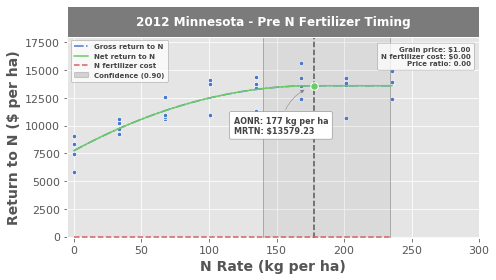

In [6]:
my_eonr.calculate_eonr(df_data)
my_eonr.plot_eonr(x_min=-5, x_max=300, y_min=-100, y_max=18000)

We see that the _**agronomic**_ optimum nitrogen rate was calculated as **177** kg per ha, and the MRTN is **13.579 Mg per ha** (yes, it says $13,579, but because `price_grain` was set to \\$1, the values are equivalent and the units can be substituted.

If you've gone through the [first tutorial](tutorial.md), you'll notice there are a few major differences in the look of this plot:

**The red line representing nitrogen fertilizer cost is on the bottom of the plot**
*This happened because* `cost_n_fert` *was set to zero, and nitrogen fertilizer cost is simply being plotted as a flat horizontal line at $\text{y}=0$*


**The blue line is missing?**
*The gross return to nitrogen (GRTN) line representing the best-fit of the quadratic-plateau model (blue line) is there, but it is actually being covered up by the green line (net return to nitrogen; NRTN). This is the case because `cost_n_fert` was set to zero.

**The GRTN/NRTN lines do not pass through the y-intercept at $\text{y}=0$?**

*Because* `base_zero` *was set to* `False`, *the observed data (blue points) were not standardized as to *force* the best-fit quadratic-plateau model from passing through at* $\text{y}=0$.

- - -
### Loop through several economic conditions
`EONR` computes the optimum nitrogen rate for any economic scenario that we define. The `EONR` class is designed so the economic condidtions can be adjusted, calculating the optimum nitrogen rate after each adjustment. We just have to set up a simple loop to update the economic scenario (using `EONR.update_econ()`) and calculate the EONR (using `EONR.calculate_eonr()`).

We will also generate plots and save them to our base directory right away:


Computing EONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.44 per kg
Price grain: $0.16 per kg
Economic optimum N rate (EONR): 169.9 kg per ha [135.2, 220.9] (90.0% confidence)
Maximum return to N (MRTN): $2055.53 per ha

Computing EONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.88 per kg
Price grain: $0.16 per kg
Economic optimum N rate (EONR): 162.3 kg per ha [130.5, 207.8] (90.0% confidence)
Maximum return to N (MRTN): $1982.44 per ha

Computing EONR for Minnesota 2012 Pre
Cost of N fertilizer: $1.32 per kg
Price grain: $0.16 per kg
Economic optimum N rate (EONR): 154.8 kg per ha [125.7, 195.0] (90.0% confidence)
Maximum return to N (MRTN): $1912.67 per ha

Computing EONR for Minnesota 2012 Pre
Cost of N fertilizer: $1.76 per kg
Price grain: $0.16 per kg
Economic optimum N rate (EONR): 147.2 kg per ha [120.8, 182.4] (90.0% confidence)
Maximum return to N (MRTN): $1846.23 per ha

Computing EONR for Minnesota 2012 Pre
Cost of N fertilizer: $2.20 per kg
Price grain: $0.16 per

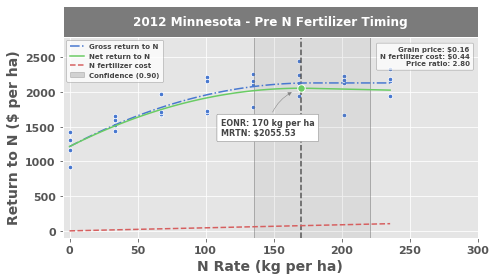

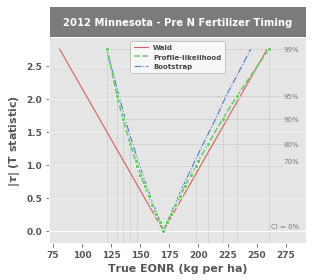

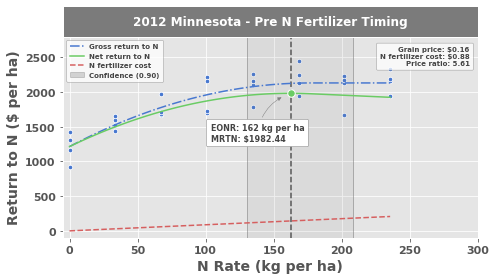

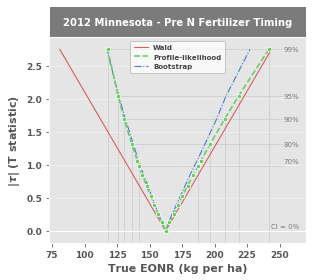

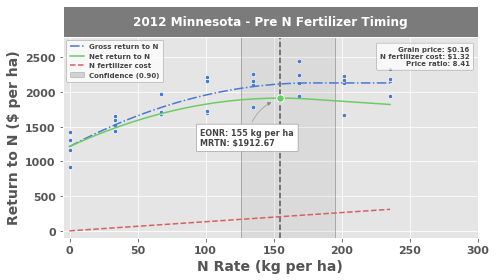

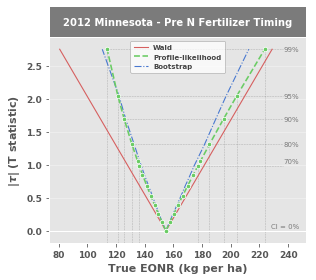

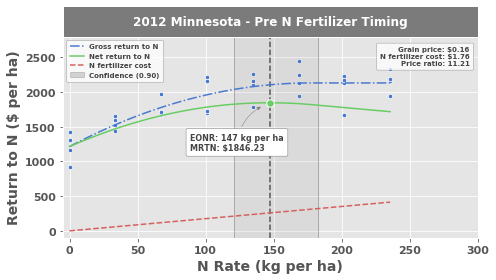

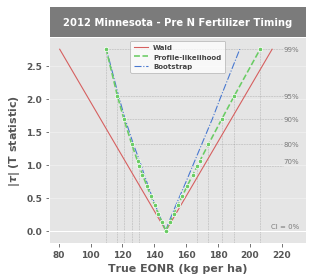

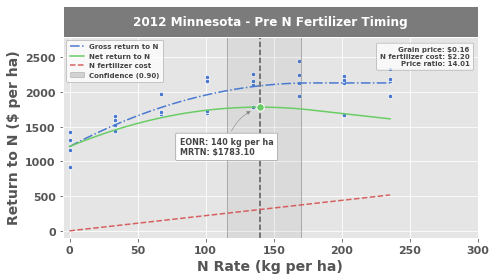

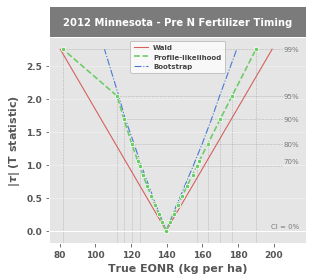

In [7]:
price_grain = 0.157  # set from $1 to 15.7 cents per kg
cost_n_fert_list = [0.44, 0.88, 1.32, 1.76, 2.20]

for cost_n_fert in cost_n_fert_list:
    # first, update fertilizer cost
    my_eonr.update_econ(cost_n_fert=cost_n_fert,
                        price_grain=price_grain)
    # second, calculate EONR
    my_eonr.calculate_eonr(df_data)
    # third, generate (and save) the plots
    my_eonr.plot_eonr(x_min=-5, x_max=300, y_min=-100, y_max=2800)
    my_eonr.plot_tau()
    my_eonr.plot_save(fname='eonr_mn2012_pre.png', fig=my_eonr.fig_eonr)
    my_eonr.plot_save(fname='tau_mn2012_pre.png', fig=my_eonr.fig_tau)    

A similar loop can be made adjusting the social cost of nitrogen. `my_eonr.base_zero` is set to `True` to compare the graphs:


Computing SONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.88 per kg
Price grain: $0.16 per kg
Social cost of N: $0.44 per kg
Socially optimum N rate (SONR): 158.7 kg per ha [128.1, 201.5] (90.0% confidence)
Maximum return to N (MRTN): $777.56 per ha

Computing SONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.88 per kg
Price grain: $0.16 per kg
Social cost of N: $0.88 per kg
Socially optimum N rate (SONR): 155.2 kg per ha [125.9, 195.7] (90.0% confidence)
Maximum return to N (MRTN): $787.96 per ha

Computing SONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.88 per kg
Price grain: $0.16 per kg
Social cost of N: $1.32 per kg
Socially optimum N rate (SONR): 151.9 kg per ha [123.8, 190.1] (90.0% confidence)
Maximum return to N (MRTN): $799.07 per ha

Computing SONR for Minnesota 2012 Pre
Cost of N fertilizer: $0.88 per kg
Price grain: $0.16 per kg
Social cost of N: $2.20 per kg
Socially optimum N rate (SONR): 145.8 kg per ha [119.9, 180.0] (90.0% confidence)
Maximum return to N

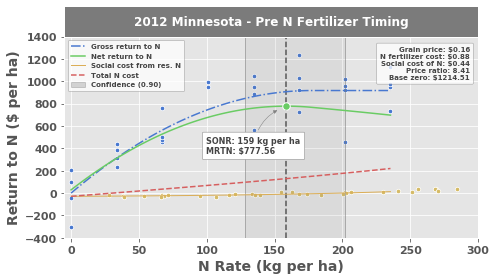

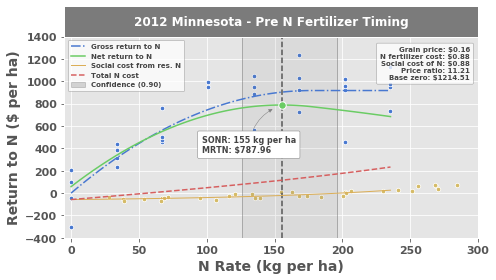

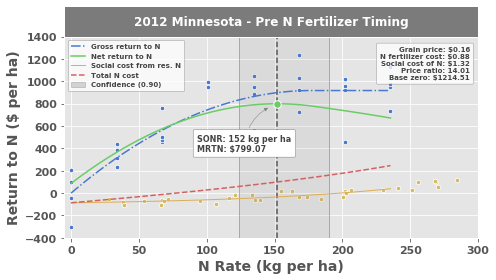

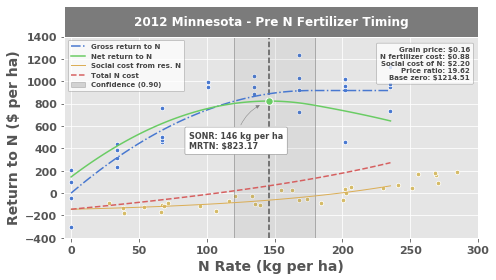

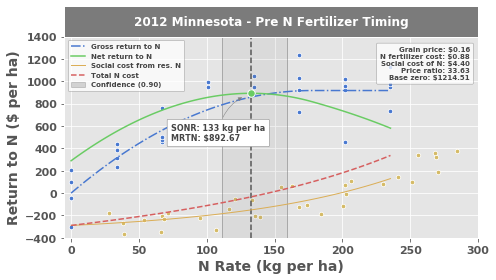

In [8]:
price_grain = 0.157  # keep at 15.7 cents per kg
cost_n_fert = 0.88  # set to be constant
my_eonr.update_econ(price_grain=price_grain,
                    cost_n_fert=cost_n_fert)
my_eonr.base_zero = True  # let's use base zero to compare graphs

cost_n_social_list = [0.44, 0.88, 1.32, 2.20, 4.40]

for cost_n_social in cost_n_social_list:
    # first, update social cost
    my_eonr.update_econ(cost_n_social=cost_n_social)
    # second, calculate EONR
    my_eonr.calculate_eonr(df_data)
    # third, generate (and save) the plots
    my_eonr.plot_eonr(x_min=-5, x_max=300, y_min=-400, y_max=1400)
#     my_eonr.plot_tau()
    my_eonr.plot_save(fname='eonr_mn2012_pre.png', fig=my_eonr.fig_eonr)
#     my_eonr.plot_save(fname='tau_mn2012_pre.png', fig=my_eonr.fig_tau)


Notice that we used the same `EONR` instance (`my_eonr`) for all runs. This can be done if there are mnay combinations of economic scenarios, or many expermintal datasets, that you'd like to loop through. If you'd like the results to be saved separate (perhaps to separate results depending if a social cost is considered) that's fine too. Simply create a new instance of `EONR` and customize how you'd like.
- - -
### View results
All eleven runs can be viewed in the dataframe:

In [9]:
my_eonr.df_results

,price_grain,cost_n_fert,cost_n_social,price_ratio,location,year,time_n,base_zero,eonr,theta2_error,...,mrtn,grtn_r2_adj,grtn_rmse,grtn_max_y,grtn_crit_x,grtn_y_int,scn_lin_r2,scn_lin_rmse,scn_exp_r2,scn_exp_rmse
0,1.000,0,0,0.000000,Minnesota,2012,Pre,7735.725352,177.437339,0.002644,...,13579.232456,0.728926,1154.305686,13579.232456,177.437339,7735.725352,None,None,None,None
1,0.157,0.44,0,2.802548,Minnesota,2012,Pre,1214.508882,169.887470,0.002419,...,2055.528038,0.728926,181.225993,2131.939496,177.437340,1214.508882,None,None,None,None
2,0.157,0.88,0,5.605096,Minnesota,2012,Pre,1214.508882,162.337602,0.002195,...,1982.438523,0.728926,181.225993,2131.939496,177.437340,1214.508882,None,None,None,None
3,0.157,1.32,0,8.407643,Minnesota,2012,Pre,1214.508882,154.787732,0.001967,...,1912.670950,0.728926,181.225993,2131.939496,177.437340,1214.508882,None,None,None,None
4,0.157,1.76,0,11.210191,Minnesota,2012,Pre,1214.508882,147.237859,0.001745,...,1846.225321,0.728926,181.225993,2131.939496,177.437340,1214.508882,None,None,None,None
5,0.157,2.2,0,14.012739,Minnesota,2012,Pre,1214.508882,139.687987,0.001523,...,1783.101634,0.728926,181.225993,2131.939496,177.437340,1214.508882,None,None,None,None
6,0.157,0.88,0.44,8.407643,Minnesota,2012,Pre,1214.508882,158.662218,-0.000440,...,777.563499,0.728926,181.225993,917.431894,177.440056,1214.508882,0.777106,55.7255,0.836099,8.44737
7,0.157,0.88,0.88,11.210191,Minnesota,2012,Pre,1214.508882,155.193581,-0.000348,...,787.963773,0.728926,181.225993,917.431894,177.440056,1214.508882,0.777106,111.451,0.836099,16.8947
8,0.157,0.88,1.32,14.012739,Minnesota,2012,Pre,1214.508882,151.908893,-0.000261,...,799.067077,0.728926,181.225993,917.431894,177.440056,1214.508882,0.777106,167.176,0.836099,25.3421
9,0.157,0.88,2.2,19.617834,Minnesota,2012,Pre,1214.508882,145.812908,-0.000099,...,823.173264,0.728926,181.225993,917.431894,177.440056,1214.508882,0.777106,278.627,0.836099,42.2368


Notice the *"price_ratio"*, *"eonr"*, *"mrtn"*, *etc.* are different for each scenario. 
- - -
### Save the data
The results generated by `EONR` can be saved to the `EONR.base_dir` using the `Pandas` `df.to_csv()` function. A folder will be created in the base_dir whose name is determined by the _**current economic scenario**_ of `my_eonr` (in this case "social_336_4400", corresponding to `cost_n_social > 0`, `price_ratio == 33.6`, and `cost_n_social == 4.40` for "social", "336", and "4400" in the folder name, respectively):

In [10]:
print(my_eonr.base_dir)

my_eonr.df_results.to_csv(os.path.join(os.path.split(my_eonr.base_dir)[0], 'advanced_tutorial_results.csv'), index=False)
my_eonr.df_ci.to_csv(os.path.join(os.path.split(my_eonr.base_dir)[0], 'advanced_tutorial_ci.csv'), index=False)

F:\nigo0024\Documents\GitHub\eonr\eonr\examples\eonr_advanced_tutorial\social_336_4400
